In [177]:
import wandb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score, roc_auc_score



In [178]:
import sys
sys.path.insert(0, '/home/er647/projects/feature-wise-active-learning/src')

In [179]:
from models import FWAL
from dataset import create_data_module

In [180]:

entity = "evangeorgerex"
project = "fwal"
sweep_id = "z9b6sox8"

In [181]:
wandb.init(project="fwal",entity="evangeorgerex")

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [182]:
from argparse import Namespace

args = Namespace(
    lr=0.001,
    reconstruction_loss='mse',
    concrete_anneal_iterations=0,
    mask_init_value=None,
    mask_init_p_array=None,
    seed_model_mask=0,
    dataset='madelon',
    dataset_size=None,
    evaluate_with_sampled_datasets=False,
    data_dir='/home/er647/data/fwal-data',
    restrict_features=False,
    dataset_feature_set='hallmark',
    cv_folds=5,
    seed_kfold=None,
    test_split=0,
    valid_percentage=0.25,
    seed_validation=None,
    train_on_full_data=False,
    patient_preprocessing='standard',
    class_weight='balanced',
    max_steps=10000,
    hpc_run=False,
    overfit_batches=0,
    deterministic=True,
    num_workers=5,
    pin_memory=True,
    persistent_workers=False,
    valid_aug_dropout_p=None,
    test_time_interventions_in_progress=False,
    as_MLP_baseline=False,
    mask_type='gumbel_softmax',
    only_reconstruct_masked=True,
    gamma=1.0,
    sparsity_regularizer='L1',
    sparsity_regularizer_hyperparam=1.0,
    normalize_sparsity=True,
    normalize_reconstruction='num_non_masked_features',
    model='fwal',
    pretrain=False,
    num_necessary_features=0
    )
data_module = create_data_module(args)


Train size: 1560

Valid size: 520

Test size: 520

Weights for the classification loss: [1. 1.]


In [183]:


# Assuming your checkpoint path is as follows
checkpoint_path = '/home/er647/data/fwal-data/fwal/n63ewqi8/checkpoints/epoch=53-step=646.ckpt'

# Load the model from the checkpoint
model = FWAL.load_from_checkpoint(checkpoint_path, args=args)

# Now you can use `model` for inference, further training, etc.


In [184]:
trainer = pl.Trainer(
	# Training
	max_steps=args.max_steps,
	gradient_clip_val=2.5,

	# logging
	# logger=wandb_logger,
	# log_every_n_steps = 1,
	# val_check_interval = args.val_check_interval,
	# callbacks = callbacks,

	# miscellaneous
	accelerator="auto",
	devices="auto",
	detect_anomaly= (not args.hpc_run),
	overfit_batches=args.overfit_batches,
	deterministic=args.deterministic,
)

You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [174]:
        
def get_labels_lists(outputs):
	all_y_true, all_y_pred = [], []
	for output in outputs:
		all_y_true.extend(output['y_true'].detach().cpu().numpy().tolist())
		all_y_pred.extend(output['y_pred'].detach().cpu().numpy().tolist())

	return all_y_true, all_y_pred

def evaluate(model, dataloader):
    outputs = [model.test_step(batch, batch_idx) for batch_idx, batch in enumerate(dataloader)]
    avg_losses = {loss: np.mean([output['losses'][loss].item() for output in outputs]) for loss in ['total', 'reconstruction', 'cross_entropy', 'sparsity']}
    
    metrics = {f"{loss}_loss": avg_losses[loss] for loss in avg_losses}
    y_true, y_pred = get_labels_lists(outputs)
    metrics.update({
        'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
        'F1_weighted': f1_score(y_true, y_pred, average='weighted'),
        'precision_weighted': precision_score(y_true, y_pred, average='weighted'),
        'recall_weighted': recall_score(y_true, y_pred, average='weighted'),
    })
    
    if model.args.num_classes == 2:
        metrics['AUROC_weighted'] = roc_auc_score(y_true, y_pred, average='weighted')
    
    return metrics


def evaluate_test_time_interventions(model, data_module, args):
    model.args.test_time_interventions_in_progress = True
    num_necessary_features = int(model.necessary_features().float().sum().item())
    end = args.num_features - num_necessary_features
    
    max_steps = 10
    num_steps = min(max_steps, end + 1)
    
    for k in np.linspace(0, end, num_steps, dtype=int):
        model.args.num_additional_features = k
        valid_metrics = evaluate(model, data_module.val_dataloader()[0])
        test_metrics = evaluate(model, data_module.test_dataloader())
        
        print({
            'num_additional_features': k,
            'tti_valid_metrics': valid_metrics,
            'tti_test_metrics': test_metrics
        })



In [187]:
evaluate_test_time_interventions(model, data_module, args)

Created 1 validation dataloaders.


/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

{'num_additional_features': 0, 'tti_valid_metrics': {'total_loss': 6.3441160202026365, 'reconstruction_loss': 4.7439360320568085, 'cross_entropy_loss': 0.8215062886476516, 'sparsity_loss': 0.7786735892295837, 'balanced_accuracy': 0.8557692307692308, 'F1_weighted': 0.8556790301630827, 'precision_weighted': 0.8566608829766725, 'recall_weighted': 0.8557692307692307, 'AUROC_weighted': 0.8557692307692308}, 'tti_test_metrics': {'total_loss': 6.701117944717407, 'reconstruction_loss': 4.730796921253204, 'cross_entropy_loss': 1.191647356748581, 'sparsity_loss': 0.7786735892295837, 'balanced_accuracy': 0.875, 'F1_weighted': 0.8747549755253435, 'precision_weighted': 0.8779576866305855, 'recall_weighted': 0.875, 'AUROC_weighted': 0.875}}
Created 1 validation dataloaders.


/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

{'num_additional_features': 2, 'tti_valid_metrics': {'total_loss': 5.902459716796875, 'reconstruction_loss': 4.290503305196762, 'cross_entropy_loss': 0.8332827597856521, 'sparsity_loss': 0.7786735892295837, 'balanced_accuracy': 0.8557692307692308, 'F1_weighted': 0.8556790301630827, 'precision_weighted': 0.8566608829766725, 'recall_weighted': 0.8557692307692307, 'AUROC_weighted': 0.8557692307692308}, 'tti_test_metrics': {'total_loss': 6.192649841308594, 'reconstruction_loss': 4.2626598238945, 'cross_entropy_loss': 1.1513163805007935, 'sparsity_loss': 0.7786735892295837, 'balanced_accuracy': 0.8730769230769231, 'F1_weighted': 0.8728888888888889, 'precision_weighted': 0.875297619047619, 'recall_weighted': 0.8730769230769231, 'AUROC_weighted': 0.8730769230769231}}
Created 1 validation dataloaders.


/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

{'num_additional_features': 4, 'tti_valid_metrics': {'total_loss': 5.3788292646408085, 'reconstruction_loss': 3.7672391504049303, 'cross_entropy_loss': 0.8329164385795593, 'sparsity_loss': 0.7786735892295837, 'balanced_accuracy': 0.8557692307692308, 'F1_weighted': 0.8556790301630827, 'precision_weighted': 0.8566608829766725, 'recall_weighted': 0.8557692307692307, 'AUROC_weighted': 0.8557692307692308}, 'tti_test_metrics': {'total_loss': 5.719534826278687, 'reconstruction_loss': 3.763502961397171, 'cross_entropy_loss': 1.177358204126358, 'sparsity_loss': 0.7786735892295837, 'balanced_accuracy': 0.8711538461538462, 'F1_weighted': 0.8709815989542251, 'precision_weighted': 0.8731465369800265, 'recall_weighted': 0.8711538461538462, 'AUROC_weighted': 0.8711538461538462}}
Created 1 validation dataloaders.


/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

{'num_additional_features': 6, 'tti_valid_metrics': {'total_loss': 4.904067468643189, 'reconstruction_loss': 3.285432958602905, 'cross_entropy_loss': 0.8399608492851257, 'sparsity_loss': 0.7786735892295837, 'balanced_accuracy': 0.8596153846153847, 'F1_weighted': 0.8595275893587337, 'precision_weighted': 0.86051667630615, 'recall_weighted': 0.8596153846153847, 'AUROC_weighted': 0.8596153846153846}, 'tti_test_metrics': {'total_loss': 5.187774801254273, 'reconstruction_loss': 3.2394728004932403, 'cross_entropy_loss': 1.1696283042430877, 'sparsity_loss': 0.7786735892295837, 'balanced_accuracy': 0.8711538461538462, 'F1_weighted': 0.8709433654740164, 'precision_weighted': 0.8735910302416653, 'recall_weighted': 0.8711538461538462, 'AUROC_weighted': 0.8711538461538463}}
Created 1 validation dataloaders.


/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

{'num_additional_features': 8, 'tti_valid_metrics': {'total_loss': 4.420966172218323, 'reconstruction_loss': 2.7838631540536882, 'cross_entropy_loss': 0.8584293484687805, 'sparsity_loss': 0.7786735892295837, 'balanced_accuracy': 0.8576923076923078, 'F1_weighted': 0.8576164821502575, 'precision_weighted': 0.8584558823529411, 'recall_weighted': 0.8576923076923076, 'AUROC_weighted': 0.8576923076923078}, 'tti_test_metrics': {'total_loss': 4.709266090393067, 'reconstruction_loss': 2.7699161887168886, 'cross_entropy_loss': 1.160676246881485, 'sparsity_loss': 0.7786735892295837, 'balanced_accuracy': 0.8692307692307693, 'F1_weighted': 0.869037037037037, 'precision_weighted': 0.8714285714285713, 'recall_weighted': 0.8692307692307693, 'AUROC_weighted': 0.8692307692307693}}
Created 1 validation dataloaders.


/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

{'num_additional_features': 10, 'tti_valid_metrics': {'total_loss': 3.921038198471069, 'reconstruction_loss': 2.280905306339264, 'cross_entropy_loss': 0.8614593029022217, 'sparsity_loss': 0.7786735892295837, 'balanced_accuracy': 0.8557692307692308, 'F1_weighted': 0.8557260125999282, 'precision_weighted': 0.8561960337090301, 'recall_weighted': 0.8557692307692307, 'AUROC_weighted': 0.8557692307692308}, 'tti_test_metrics': {'total_loss': 4.173184776306153, 'reconstruction_loss': 2.242098957300186, 'cross_entropy_loss': 1.1524122476577758, 'sparsity_loss': 0.7786735892295837, 'balanced_accuracy': 0.8692307692307693, 'F1_weighted': 0.869037037037037, 'precision_weighted': 0.8714285714285713, 'recall_weighted': 0.8692307692307693, 'AUROC_weighted': 0.8692307692307693}}
Created 1 validation dataloaders.


/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

{'num_additional_features': 12, 'tti_valid_metrics': {'total_loss': 3.4142173528671265, 'reconstruction_loss': 1.7752147912979126, 'cross_entropy_loss': 0.8603289604187012, 'sparsity_loss': 0.7786735892295837, 'balanced_accuracy': 0.851923076923077, 'F1_weighted': 0.851896238593532, 'precision_weighted': 0.8521783541324333, 'recall_weighted': 0.8519230769230769, 'AUROC_weighted': 0.851923076923077}, 'tti_test_metrics': {'total_loss': 3.684889888763428, 'reconstruction_loss': 1.7502785056829453, 'cross_entropy_loss': 1.1559376835823059, 'sparsity_loss': 0.7786735892295837, 'balanced_accuracy': 0.8730769230769231, 'F1_weighted': 0.8728888888888889, 'precision_weighted': 0.875297619047619, 'recall_weighted': 0.8730769230769231, 'AUROC_weighted': 0.8730769230769231}}
Created 1 validation dataloaders.


/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

{'num_additional_features': 14, 'tti_valid_metrics': {'total_loss': 2.8664974927902223, 'reconstruction_loss': 1.2349192634224893, 'cross_entropy_loss': 0.8529046297073364, 'sparsity_loss': 0.7786735892295837, 'balanced_accuracy': 0.851923076923077, 'F1_weighted': 0.851896238593532, 'precision_weighted': 0.8521783541324333, 'recall_weighted': 0.8519230769230769, 'AUROC_weighted': 0.851923076923077}, 'tti_test_metrics': {'total_loss': 3.1868300914764403, 'reconstruction_loss': 1.2430814325809478, 'cross_entropy_loss': 1.1650749802589417, 'sparsity_loss': 0.7786735892295837, 'balanced_accuracy': 0.8673076923076923, 'F1_weighted': 0.8671303034006198, 'precision_weighted': 0.8692797334880055, 'recall_weighted': 0.8673076923076923, 'AUROC_weighted': 0.8673076923076924}}
Created 1 validation dataloaders.


/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

{'num_additional_features': 16, 'tti_valid_metrics': {'total_loss': 2.3724223613739013, 'reconstruction_loss': 0.7433925062417984, 'cross_entropy_loss': 0.8503562092781067, 'sparsity_loss': 0.7786735892295837, 'balanced_accuracy': 0.8557692307692308, 'F1_weighted': 0.8557430895391548, 'precision_weighted': 0.8560272978934435, 'recall_weighted': 0.8557692307692307, 'AUROC_weighted': 0.8557692307692308}, 'tti_test_metrics': {'total_loss': 2.7276214122772218, 'reconstruction_loss': 0.7703333340585232, 'cross_entropy_loss': 1.1786144971847534, 'sparsity_loss': 0.7786735892295837, 'balanced_accuracy': 0.8711538461538462, 'F1_weighted': 0.8710159897227437, 'precision_weighted': 0.872747396413662, 'recall_weighted': 0.8711538461538462, 'AUROC_weighted': 0.8711538461538463}}
Created 1 validation dataloaders.


/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

{'num_additional_features': 19, 'tti_valid_metrics': {'total_loss': 1.626792883872986, 'reconstruction_loss': 0.0, 'cross_entropy_loss': 0.8481193006038665, 'sparsity_loss': 0.7786735892295837, 'balanced_accuracy': 0.8576923076923078, 'F1_weighted': 0.8576586174242424, 'precision_weighted': 0.8580312722103767, 'recall_weighted': 0.8576923076923076, 'AUROC_weighted': 0.8576923076923078}, 'tti_test_metrics': {'total_loss': 1.9648981094360352, 'reconstruction_loss': 0.0, 'cross_entropy_loss': 1.186224502325058, 'sparsity_loss': 0.7786735892295837, 'balanced_accuracy': 0.8711538461538462, 'F1_weighted': 0.8710465439067271, 'precision_weighted': 0.8723933209647496, 'recall_weighted': 0.8711538461538462, 'AUROC_weighted': 0.8711538461538463}}


In [186]:
evaluate(model, data_module.test_dataloader())

/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'total_loss': 6.701117944717407,
 'reconstruction_loss': 4.730796921253204,
 'cross_entropy_loss': 1.191647356748581,
 'sparsity_loss': 0.7786735892295837,
 'balanced_accuracy': 0.875,
 'F1_weighted': 0.8747549755253435,
 'precision_weighted': 0.8779576866305855,
 'recall_weighted': 0.875,
 'AUROC_weighted': 0.875}

In [164]:
valid_metrics = evaluate(model, data_module.val_dataloader()[0])

Created 1 validation dataloaders.


/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [165]:
valid_metrics

{'total_loss': 6.59875259399414,
 'reconstruction_loss': 4.722161042690277,
 'cross_entropy_loss': 1.097917950153351,
 'sparsity_loss': 0.7786735892295837,
 'balanced_accuracy': 0.8288461538461538,
 'F1_weighted': 0.8287948682852481,
 'precision_weighted': 0.8292406581851034,
 'recall_weighted': 0.8288461538461539,
 'AUROC_weighted': 0.8288461538461538}

In [185]:
trainer.test(model, dataloaders=data_module.test_dataloader(), ckpt_path=checkpoint_path)

Restoring states from the checkpoint path at /home/er647/data/fwal-data/fwal/n63ewqi8/checkpoints/epoch=53-step=646.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/er647/data/fwal-data/fwal/n63ewqi8/checkpoints/epoch=53-step=646.ckpt


/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    None/AUROC_weighted    │           0.875           │
│     None/F1_weighted      │    0.8747549755253435     │
│  None/balanced_accuracy   │           0.875           │
│  None/cross_entropy_loss  │    1.1916471719741821     │
│  None/precision_weighted  │    0.8779576866305855     │
│   None/recall_weighted    │           0.875           │
│ None/reconstruction_loss  │     4.730796813964844     │
│    None/sparsity_loss     │    0.7786736488342285     │
│      None/total_loss      │     6.701117515563965     │
└───────────────────────────┴───────────────────────────┘

/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[{'None/total_loss': 6.701117515563965,
  'None/reconstruction_loss': 4.730796813964844,
  'None/cross_entropy_loss': 1.1916471719741821,
  'None/sparsity_loss': 0.7786736488342285,
  'None/balanced_accuracy': 0.875,
  'None/F1_weighted': 0.8747549755253435,
  'None/precision_weighted': 0.8779576866305855,
  'None/recall_weighted': 0.875,
  'None/AUROC_weighted': 0.875}]

In [160]:
trainer.test(model, dataloaders=data_module.val_dataloader()[0], ckpt_path=checkpoint_path)

Restoring states from the checkpoint path at /home/er647/data/fwal-data/fwal/n63ewqi8/checkpoints/epoch=53-step=646.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/er647/data/fwal-data/fwal/n63ewqi8/checkpoints/epoch=53-step=646.ckpt


Created 1 validation dataloaders.


/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    None/AUROC_weighted    │    0.8288461538461538     │
│     None/F1_weighted      │    0.8287948682852481     │
│  None/balanced_accuracy   │    0.8288461538461538     │
│  None/cross_entropy_loss  │    1.0979180335998535     │
│  None/precision_weighted  │    0.8292406581851034     │
│   None/recall_weighted    │    0.8288461538461539     │
│ None/reconstruction_loss  │     4.722160339355469     │
│    None/sparsity_loss     │    0.7786736488342285     │
│      None/total_loss      │     6.598752021789551     │
└───────────────────────────┴───────────────────────────┘

/home/er647/.conda/envs/fwal/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[{'None/total_loss': 6.598752021789551,
  'None/reconstruction_loss': 4.722160339355469,
  'None/cross_entropy_loss': 1.0979180335998535,
  'None/sparsity_loss': 0.7786736488342285,
  'None/balanced_accuracy': 0.8288461538461538,
  'None/F1_weighted': 0.8287948682852481,
  'None/precision_weighted': 0.8292406581851034,
  'None/recall_weighted': 0.8288461538461539,
  'None/AUROC_weighted': 0.8288461538461538}]

In [3]:

# Initialize wandb API
api = wandb.Api()

# Fetch all runs in your sweep
sweep_runs = api.sweep(f"{entity}/{project}/{sweep_id}").runs

# Prepare a list to collect data
data = []

# Extract data from each run
for run in sweep_runs:
    history = run.scan_history(keys=['num_additional_features', 'tti_valid_metrics'])
    for row in history:
        if 'tti_valid_metrics' in row and 'F1_weighted' in row['tti_valid_metrics']:
            data.append({
                'num_additional_features': row['num_additional_features'],
                'F1_weighted': row['tti_valid_metrics']['F1_weighted']
            })

# Convert data to DataFrame
df = pd.DataFrame(data)



In [20]:
runpath = "evangeorgerex/fwal/m1l5bzbb" # only reconstruct masked madelon
# runpath = "evangeorgerex/fwal/aur50m7o" # only reconstruct masked mice protein

run = api.run(runpath)

In [21]:
history_data = []

for metrics in run.scan_history():
    history_data.append(metrics)

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(history_data)
    

In [22]:
df['num_additional_features'].value_counts()

0.0     1
1.0     1
3.0     1
4.0     1
6.0     1
7.0     1
9.0     1
10.0    1
12.0    1
14.0    1
Name: num_additional_features, dtype: int64

In [27]:
df['bestmodel_valid/F1_weighted'].dropna()

2990    0.904178
Name: bestmodel_valid/F1_weighted, dtype: float64

<Axes: xlabel='num_additional_features', ylabel='tti_valid_metrics.F1_weighted'>

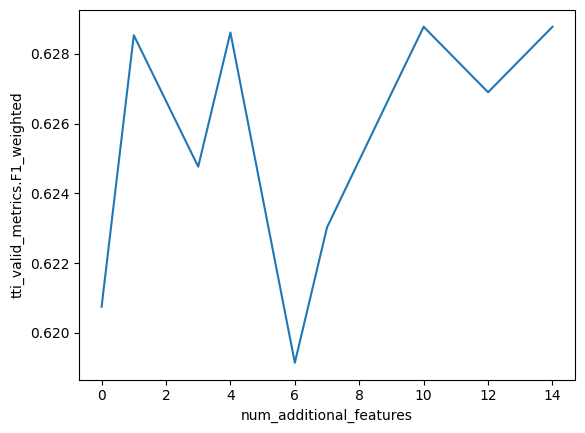

In [24]:
sns.lineplot(data=df, x='num_additional_features', y='tti_valid_metrics.F1_weighted')

In [4]:
df.head()

""


In [ ]:

# Calculate mean and std of F1_weighted for each num_additional_features
grouped_df = df.groupby('num_additional_features').agg(['mean', 'std']).reset_index()
grouped_df.columns = ['num_additional_features', 'F1_weighted_mean', 'F1_weighted_std']

# Plot using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.errorbar(data=grouped_df, x='num_additional_features', y='F1_weighted_mean', yerr='F1_weighted_std', fmt='-o', ecolor='g', capthick=2)
plt.title('F1_weighted vs. Number of Additional Features')
plt.xlabel('Number of Additional Features')
plt.ylabel('F1_weighted (mean ± std)')
plt.show()